# Importing the Libraries

In [1]:
## Most Important
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from PIL import Image

## less Important
from functools import partial
import os
from scipy import stats
import missingno as msno
import joblib
import tarfile
import shutil
import urllib
from skimage import io
## Sklearn
from sklearn import datasets
## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
## Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
## tensorflow & Keras
import tensorflow as tf    ## i will use tf for every thing and for keras using tf.keras
import keras
from keras.models import Model,Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input,LeakyReLU,AveragePooling2D
from keras.layers.normalization import batch_normalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


# Exploratory Analysis

In [2]:
#this loads multiple images 
ic_train = io.ImageCollection('/kaggle/input/arabic-hwr-ai-pro-intake1/train/*.png')

print('Type:', type(ic_train))
print("number of training data",len(ic_train))

Type: <class 'skimage.io.collection.ImageCollection'>
number of training data 13440


In [3]:
ic_test = io.ImageCollection('/kaggle/input/arabic-hwr-ai-pro-intake1/test/*.png')

print("number of test data",len(ic_test))

number of test data 3360


In [4]:
train_dir='/kaggle/input/arabic-hwr-ai-pro-intake1/train/'
train_imgs=os.listdir(train_dir)

# Visualizing images 

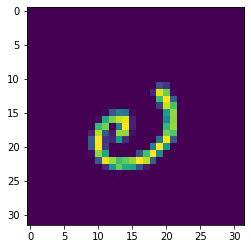

In [5]:
##first way:opencv
 ## second way :pil
# # creating a object (not returned as numpy array ,opens in new window)
im = Image.open(os.path.join(train_dir,train_imgs[0])) 
# im.show()
# convert image to numpy array
data = np.asarray(im)
plt.imshow(data);

<class 'numpy.ndarray'>
uint8
(32, 32, 4)
1 255


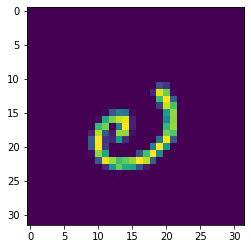

In [6]:
## third method skimage io
image = io.imread(os.path.join(train_dir,train_imgs[0]))

print(type(image))
print(image.dtype)
print(image.shape)
print(image.min(), image.max())

plt.imshow(image);

<class 'numpy.ndarray'>
float32
(32, 32, 4)
0.003921569 1.0


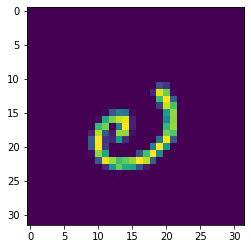

In [7]:
## fourth way using plt
image = plt.imread(os.path.join(train_dir,train_imgs[0]))
print(type(image))
print(image.dtype)
print(image.shape)
print(image.min(), image.max())
plt.imshow(image);

In [8]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

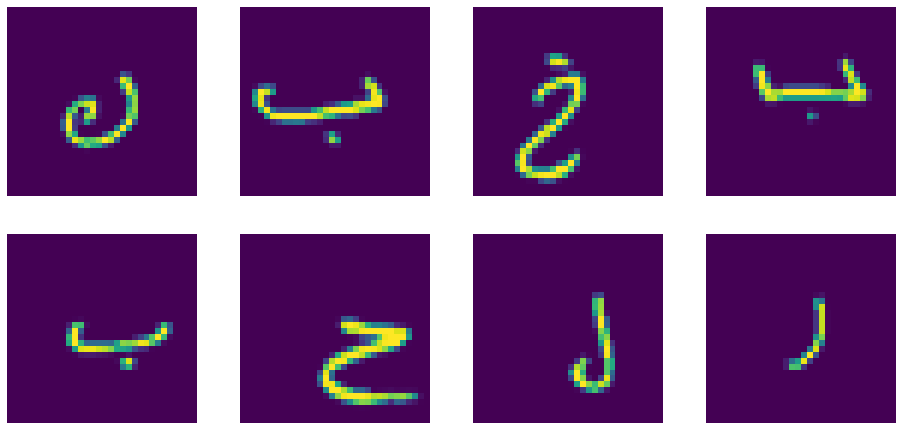

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_img = [os.path.join(train_dir, fname) 
                for fname in train_imgs[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(next_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = plt.imread(img_path)
  plt.imshow(img)

plt.show()


# Preparing Train Data for training 

In [10]:
train_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/train.csv')
train_images = Path(r'../input/arabic-hwr-ai-pro-intake1/train')

## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_images.glob(r'*.png'))), name='Filepath').astype(str)

train_images_paths.head()

0    ../input/arabic-hwr-ai-pro-intake1/train/00000...
1    ../input/arabic-hwr-ai-pro-intake1/train/00001...
2    ../input/arabic-hwr-ai-pro-intake1/train/00002...
3    ../input/arabic-hwr-ai-pro-intake1/train/00003...
4    ../input/arabic-hwr-ai-pro-intake1/train/00004...
Name: Filepath, dtype: object

In [11]:
train_full_labels = train_labels['label'].values
train_full_set = np.empty((13440, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(train_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    train_full_set[idx] = img
    
print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)

train_full_set.shape => (13440, 32, 32, 3)
train_full_labels.shape => (13440,)


# Preparing Test Data :

In [12]:
test_labels = pd.read_csv('../input/arabic-hwr-ai-pro-intake1/test.csv')
test_images = Path(r'../input/arabic-hwr-ai-pro-intake1/test')

## read these all training images paths as Series
test_images_paths = pd.Series(sorted(list(test_images.glob(r'*.png'))), name='Filepath').astype(str)

test_images_paths.head()


print('Number of Instances in test_set is', len(test_images_paths))



Number of Instances in test_set is 3360


In [13]:
test_full_set = np.empty((3360, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(test_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    test_full_set[idx] = img
    
print('test_full_set.shape =>', test_full_set.shape)

test_full_set.shape => (3360, 32, 32, 3)


## Model Building

## First Model

In [14]:
def create_model():

    
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, input_shape=(32, 32, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(1, 1)))
    
    
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu',padding="same"))
    model.add(Conv2D(filters=128, kernel_size=3, padding="valid", activation='relu'))
    
    model.add(MaxPooling2D(pool_size=2,strides=(1, 1)))
    
    
    model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=3, padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(1, 1)))
    model.add(AveragePooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(29, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


# Data Augmentation :

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        validation_split = 0.1)  # randomly flip images

In [16]:
callback_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=15),
    EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=25),
    ModelCheckpoint(
    filepath="best.hdf5",
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')
    ]

In [17]:
EPOCHS = 150
BATCH_SIZE = 128
ENSEMBLES = 10 # number of models to ensemble
result_list = [] # store results for correlation matrix
histories = [] # store histories for training and validation curves
results = np.zeros((test_full_set.shape[0],29))



for i in range(ENSEMBLES):
    # split training and validation sets
    X_train_tmp, X_val, y_train_tmp, y_val = train_test_split(train_full_set, train_full_labels, test_size=0.1, random_state=i)
    # create model
    model = create_model()
    # fit the model
    print('training No.', i)
    history = model.fit(datagen.flow(X_train_tmp, y_train_tmp, batch_size=BATCH_SIZE),
                   epochs=EPOCHS,
                   callbacks=callback_list,
                   validation_data=(X_val, y_val),
                   )
    # save results
    histories.append(history)
    result = model.predict(test_full_set)
    results += result
    result_list.append(result)

2021-11-07 13:42:17.037738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 13:42:17.115870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 13:42:17.117042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 13:42:17.120205: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

training No. 0


2021-11-07 13:42:19.955135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2021-11-07 13:42:21.340843: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


95/95 [==============================] - 16s 90ms/step - loss: 2.6003 - accuracy: 0.2315 - val_loss: 1.3934 - val_accuracy: 0.5424

Epoch 00001: val_accuracy improved from -inf to 0.54241, saving model to best.hdf5
Epoch 2/150
95/95 [==============================] - 8s 87ms/step - loss: 1.4049 - accuracy: 0.5584 - val_loss: 0.7138 - val_accuracy: 0.7649

Epoch 00002: val_accuracy improved from 0.54241 to 0.76488, saving model to best.hdf5
Epoch 3/150
95/95 [==============================] - 8s 84ms/step - loss: 0.8716 - accuracy: 0.7346 - val_loss: 0.4525 - val_accuracy: 0.8586

Epoch 00003: val_accuracy improved from 0.76488 to 0.85863, saving model to best.hdf5
Epoch 4/150
95/95 [==============================] - 8s 79ms/step - loss: 0.5856 - accuracy: 0.8179 - val_loss: 0.3158 - val_accuracy: 0.8981

Epoch 00004: val_accuracy improved from 0.85863 to 0.89807, saving model to best.hdf5
Epoch 5/150
95/95 [==============================] - 8s 81ms/step - loss: 0.4257 - accuracy: 0.865

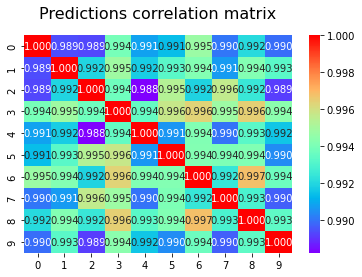

In [18]:
# check correlation of each predictions
corr_preds = pd.DataFrame([np.argmax(result, axis=1) for result in result_list]).T.corr()
fig = sns.heatmap(corr_preds, annot=True, fmt='.3f', cmap='rainbow')
fig.set_title('Predictions correlation matrix', fontsize=16, y=1.05)
plt.show()

In [19]:
loss_all_data, acc_all_data = model.evaluate(train_full_set, train_full_labels, verbose=0)
print('loss_all_data =>', loss_all_data)
print('acc_all_data =>', acc_all_data)

loss_all_data => 0.018124347552657127
acc_all_data => 0.9969494342803955


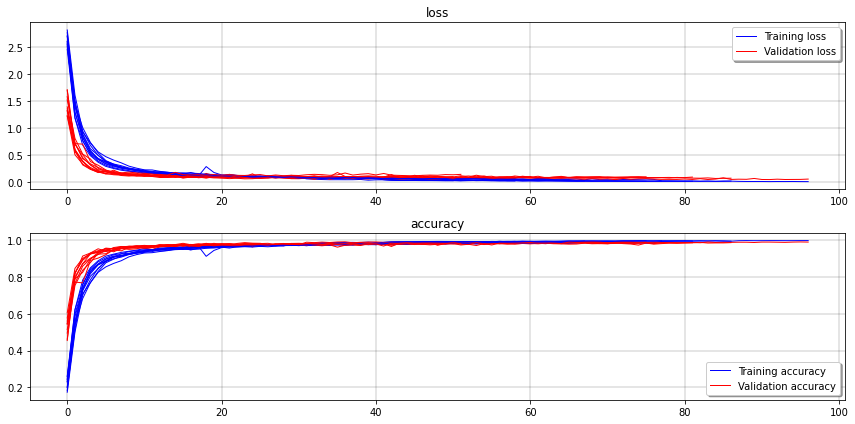

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))

for e in range(ENSEMBLES):
    loss = histories[e].history['loss']
    val_loss = histories[e].history['val_loss']
    acc = histories[e].history['accuracy']
    val_acc = histories[e].history['val_accuracy']
    ax[0].set_title('loss')
    ax[0].plot(loss, 'b', linewidth=1)
    ax[0].plot(val_loss, 'r', linewidth=1)
    ax[0].grid(color='black', linestyle='-', linewidth=0.2)
    ax[1].set_title('accuracy')
    ax[1].plot(acc, 'b', linewidth=1)
    ax[1].plot(val_acc, 'r', linewidth=1)
    ax[1].grid(color='black', linestyle='-', linewidth=0.2)
    
ax[0].legend(['Training loss', 'Validation loss'], shadow=True)     
ax[1].legend(['Training accuracy', 'Validation accuracy'], shadow=True)

plt.tight_layout()
plt.show()

# Results

In [21]:
results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

In [22]:
test_labels['label'] = results

In [23]:
test_labels['label'].value_counts()

16    125
10    125
22    123
20    123
3     123
14    123
26    122
8     121
5     121
19    121
13    121
28    120
1     120
12    120
2     120
23    120
6     120
24    120
18    119
7     119
4     118
27    118
21    118
9     118
17    116
15    116
25    116
11    114
Name: label, dtype: int64

In [24]:

 test_labels   


,id,label
0,0,26
1,1,10
2,2,1
3,3,10
4,4,15
...,...,...
3355,3355,16
3356,3356,6
3357,3357,4
3358,3358,11


# Saving Results

In [25]:
test_labels[['id', 'label']].to_csv('/kaggle/working/submission.csv', index=False)